# Goal: Predict future CPU usage (%) of cloud servers using historical system metrics.
# Target Variable (y):
- cpu_usage (continuous value, 0–100%).

#### Input Features (X):
- Numerical: memory_usage, network_traffic, power_consumption, num_executed_instructions, execution_time, energy_efficiency
- Categorical: task_type, task_priority, task_status
- Timestamp: timestamp (used to extract temporal features like hour, day, etc.)

#### Metric for Model Evaluation:
- Regression metrics: RMSE, MAE, R²

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from sklearn.model_selection import ParameterSampler
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

In [12]:
# Load dataset
df = pd.read_csv(r"C:\Users\37789\OneDrive\Documents\GitHub\Cloud_CPU_Usage_Forecasting\data\raw\cloud_metrics.csv")

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
# Quick info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   vm_id                      89962 non-null  object        
 1   timestamp                  89979 non-null  datetime64[ns]
 2   cpu_usage                  90059 non-null  float64       
 3   memory_usage               89825 non-null  float64       
 4   network_traffic            89970 non-null  float64       
 5   power_consumption          90105 non-null  float64       
 6   num_executed_instructions  89969 non-null  float64       
 7   execution_time             90175 non-null  float64       
 8   energy_efficiency          89983 non-null  float64       
 9   task_type                  89859 non-null  object        
 10  task_priority              90052 non-null  object        
 11  task_status                90093 non-null  object        
dtypes: 

In [13]:
# Preview first few rows
df.head()

,vm_id,timestamp,cpu_usage,memory_usage,network_traffic,power_consumption,num_executed_instructions,execution_time,energy_efficiency,task_type,task_priority,task_status
0,311eb0ad-23bd-4103-875f-fa62a4a34a10,2023-01-07 16:19:26,NaN,6.786253,NaN,237.377517,5085.0,71.398812,0.521228,network,medium,running
1,107b623f-5af5-4d3f-844a-3bead9bfc33a,2023-05-16 10:34:35,NaN,NaN,611.800591,447.081891,6159.0,22.838105,0.710006,compute,medium,running
2,55bb274e-9651-4e81-b584-d99a67361e5b,2023-02-19 11:51:45,65.469374,17.438900,NaN,431.311612,3607.0,21.750347,0.854134,network,high,completed
3,788fcfcb-4bc3-43a9-bf93-7ab20f867278,2023-04-03 00:09:02,19.234034,36.829767,538.278533,411.388609,7413.0,31.906851,0.153060,network,low,running
4,a1dd1d6e-1f03-4026-a136-5780ee1d0000,2023-03-22 12:20:00,66.042600,90.020999,966.344380,174.279893,3645.0,NaN,0.099798,io,low,running


### Data Sourcing and Ingestion

#### Objective:
- Understand where the data comes from and make sure it’s ready to use for modeling.
- Verify data types, missing values, and general structure.
- Source: Public cloud computing performance metrics dataset (time-series data for VMs)
- Format: CSV with 100,000 rows and 12 columns

In [14]:
# Basic inspection
print("Number of rows and columns:", df.shape)
print("\nColumns in dataset:\n", df.columns.tolist())

Number of rows and columns: (100000, 12)

Columns in dataset:
 ['vm_id', 'timestamp', 'cpu_usage', 'memory_usage', 'network_traffic', 'power_consumption', 'num_executed_instructions', 'execution_time', 'energy_efficiency', 'task_type', 'task_priority', 'task_status']


In [15]:
# Check missing values
print("\nMissing values per column:\n", df.isnull().sum())


Missing values per column:
 vm_id                        10038
timestamp                    10021
cpu_usage                     9941
memory_usage                 10175
network_traffic              10030
power_consumption             9895
num_executed_instructions    10031
execution_time                9825
energy_efficiency            10017
task_type                    10141
task_priority                 9948
task_status                   9907
dtype: int64


In [16]:
# Quick statistical overview of numerical columns
print("\nNumerical summary:\n", df.describe())


Numerical summary:
                            timestamp     cpu_usage  memory_usage  \
count                          89979  90059.000000  89825.000000   
mean   2023-04-11 07:36:42.345836288     50.054111     49.812551   
min              2023-01-01 00:01:09      0.001025      0.000600   
25%       2023-02-20 03:07:59.500000     24.969683     24.886268   
50%              2023-04-11 09:43:56     50.168027     49.876912   
75%              2023-05-31 09:09:38     75.096401     74.683546   
max              2023-07-20 12:03:53     99.999378     99.997519   
std                              NaN     28.890211     28.822919   

       network_traffic  power_consumption  num_executed_instructions  \
count     89970.000000       90105.000000               89969.000000   
mean        499.522402         249.013167                5001.707699   
min           0.000189           0.000192                   0.000000   
25%         250.002429         124.102633                2517.000000   
50%   

## Observations

- Many columns have missing values (about 10k out of 100k rows).  
- Numerical features (`cpu_usage`, `memory_usage`, etc.) are continuous.  
- Categorical features (`task_type`, `task_priority`, `task_status`) are strings.  
- `timestamp` has ~10k missing values.  

## Strategy for Imputation

| Column Type   | Method            | Reason                                                                 |
|---------------|-----------------|------------------------------------------------------------------------|
| Numerical     | Median           | Robust to outliers; suitable for uniform distributions / high-magnitude variables |
| Categorical   | Mode (most frequent) | Most representative value; simple approach for resume project        |
| Timestamp     | Drop rows        | Cannot impute meaningfully; preserves temporal integrity             |


In [17]:
# Separate numerical and categorical columns
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Fill missing values
df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

# Drop rows with missing timestamp
df = df.dropna(subset=['timestamp'])

# Verify missing values handled
print("Missing values after imputation:\n", df.isnull().sum())
print("New dataset shape:", df.shape)

Missing values after imputation:
 vm_id                        0
timestamp                    0
cpu_usage                    0
memory_usage                 0
network_traffic              0
power_consumption            0
num_executed_instructions    0
execution_time               0
energy_efficiency            0
task_type                    0
task_priority                0
task_status                  0
dtype: int64
New dataset shape: (89979, 12)


## Outlier Detection & Treatment

- Identify extreme values that could distort your regression model.  
- Cap or clip them if necessary (Winsorization), **without dropping rows**, to keep dataset size consistent.

### Strategy for this Dataset
- Apply only to **numerical features** (exclude `cpu_usage` if it’s your target).  
- Use **IQR method**:
  - Lower bound = Q1 - 1.5 × IQR  
  - Upper bound = Q3 + 1.5 × IQR  
- **Clip** any values outside this range.


In [18]:
# Function to cap outliers using IQR
def cap_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower, upper)
    return df

# Apply to all numerical columns except target
num_cols = [c for c in df.select_dtypes(include=['float64', 'int64']).columns if c != 'cpu_usage']

for col in num_cols:
    df = cap_outliers(df, col)

# Verify numerical summary after capping
print(df[num_cols].describe())


       memory_usage  network_traffic  power_consumption  \
count  89979.000000     89979.000000       89979.000000   
mean      49.801371       499.610181         248.786146   
std       27.277977       273.408413         136.906210   
min        0.000600         0.000189           0.000192   
25%       27.676235       277.611802         137.872835   
50%       49.876912       499.741079         248.422556   
75%       71.776644       721.762612         359.882821   
max       99.997519       999.987020         499.993380   

       num_executed_instructions  execution_time  energy_efficiency  
count               89979.000000    89979.000000       8.997900e+04  
mean                 5004.221529       49.857476       5.006824e-01  
std                  2734.038861       27.452261       2.733493e-01  
min                     0.000000        0.002415       1.258445e-07  
25%                  2789.000000       27.482343       2.782863e-01  
50%                  5016.000000       49.775103

## Data Consistency Checks
- Ensure the dataset is uniform and ready for feature engineering.

### Checks to Perform
- **Timestamp alignment** → Ensure no duplicate or unordered timestamps if planning to use them for time-based features.  
- **Unit consistency** → All percentages are 0–100, power in consistent units, etc.  
- **Data types** → Numerical features should be `float`, categorical features should be `object`/`string`.

In [19]:
# Check for duplicate rows
print("Duplicate rows:", df.duplicated().sum())

# Check timestamp ordering
df = df.sort_values('timestamp').reset_index(drop=True)
print("First 5 timestamps:\n", df['timestamp'].head())

# Check numerical ranges
print("\nNumerical min/max values:")
for col in num_cols:
    print(f"{col}: min={df[col].min()}, max={df[col].max()}")

# Check categorical unique values
for col in cat_cols:
    print(f"{col}: {df[col].unique()}")


Duplicate rows: 0
First 5 timestamps:
 0   2023-01-01 00:01:09
1   2023-01-01 00:05:40
2   2023-01-01 00:10:12
3   2023-01-01 00:10:27
4   2023-01-01 00:17:41
Name: timestamp, dtype: datetime64[ns]

Numerical min/max values:
memory_usage: min=0.0006001207267458, max=99.99751910569184
network_traffic: min=0.0001890489775835, max=999.987020290198
power_consumption: min=0.0001923801838943, max=499.993380392872
num_executed_instructions: min=0.0, max=9999.0
execution_time: min=0.0024150806695155, max=99.99940231146856
energy_efficiency: min=1.258445422314125e-07, max=0.9999992303658564
vm_id: ['c8e53b6b-07aa-4166-b588-a0c46ce29f3a'
 'f69768b0-b485-4fab-824f-623e49f07f29'
 '2eb7b1ab-803f-4590-b39d-7ce19b62c0db' ...
 '9eabcce6-0c8b-4e56-aef7-8ed06ed056ce'
 'b3a90d51-1ade-4eaa-85a4-422c1738c428'
 '973eb5c1-7dc1-49e9-9f4d-80fd7ab91847']
task_type: ['network' 'compute' 'io']
task_priority: ['high' 'medium' 'low']
task_status: ['running' 'waiting' 'completed']


#### Univariate Analysis

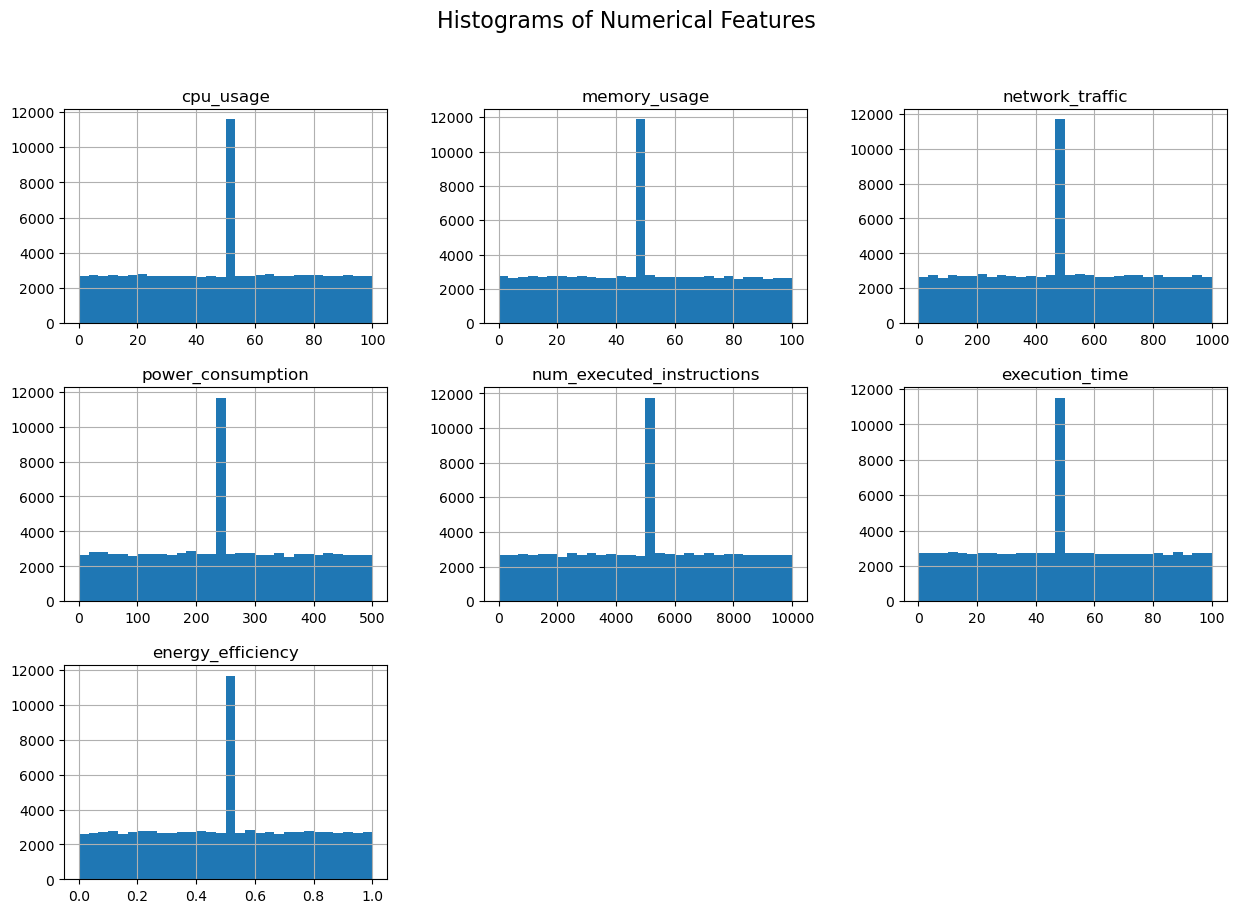

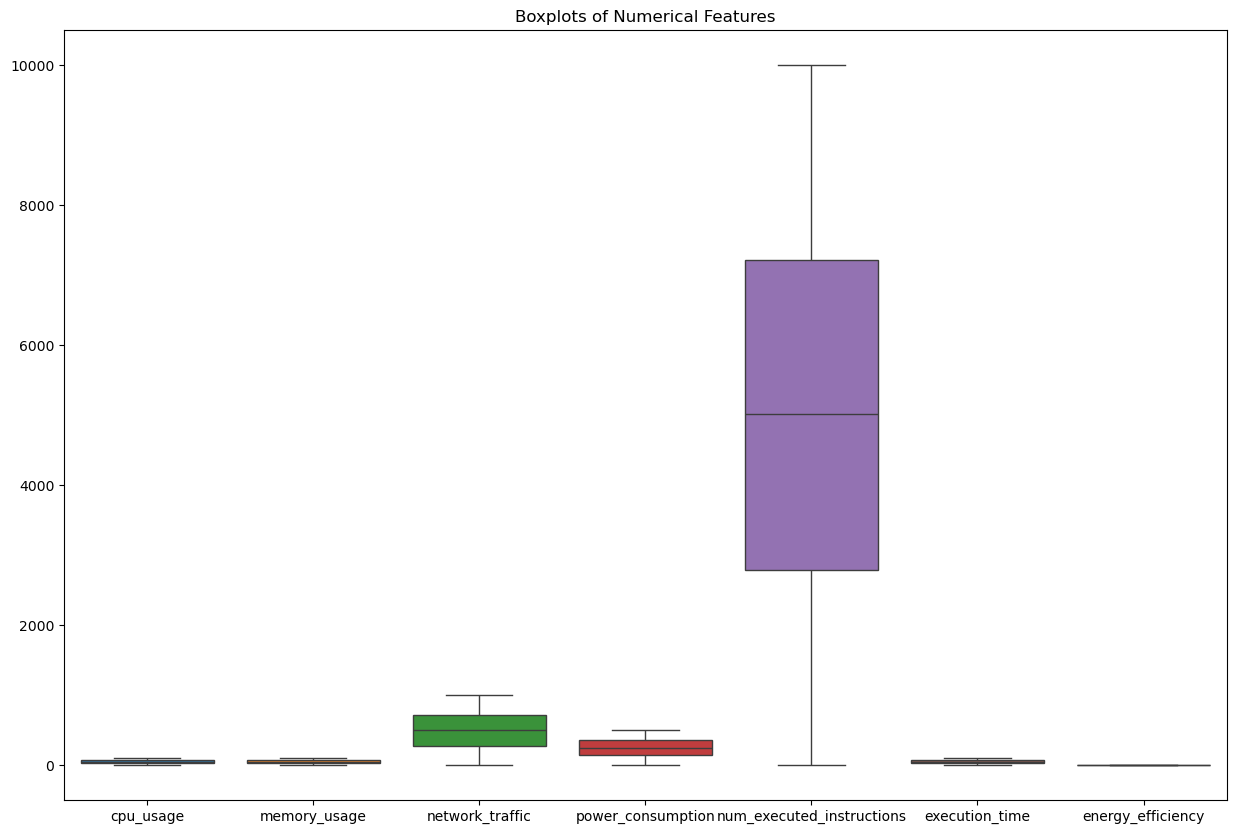

In [22]:
# List of numerical columns
num_cols = ['cpu_usage', 'memory_usage', 'network_traffic', 
            'power_consumption', 'num_executed_instructions', 
            'execution_time', 'energy_efficiency']

# Plot histograms
df[num_cols].hist(figsize=(15,10), bins=30)
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.show()

# Plot boxplots
plt.figure(figsize=(15,10))
sns.boxplot(data=df[num_cols])
plt.title("Boxplots of Numerical Features")
plt.show()

### Time-Series Specific EDA

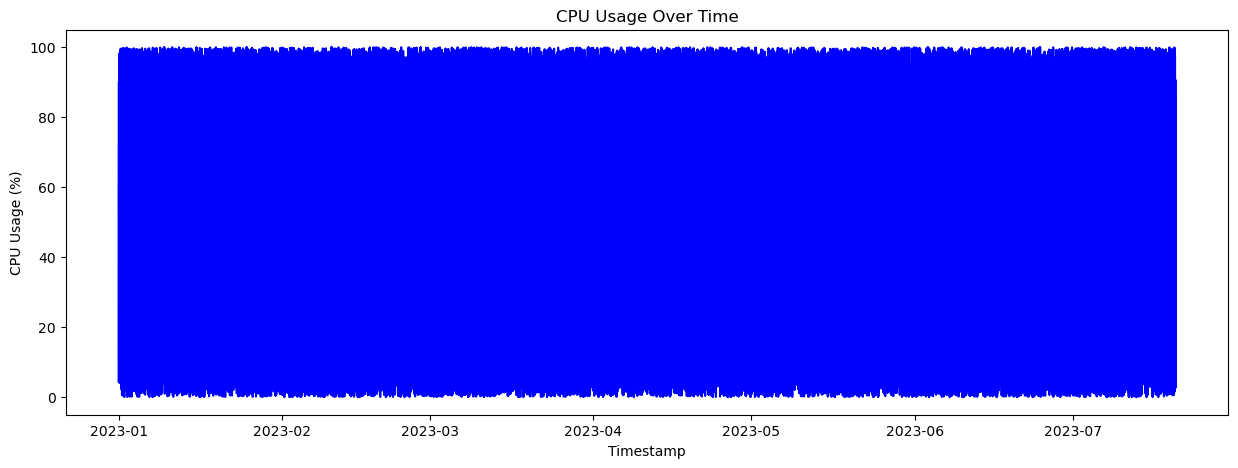

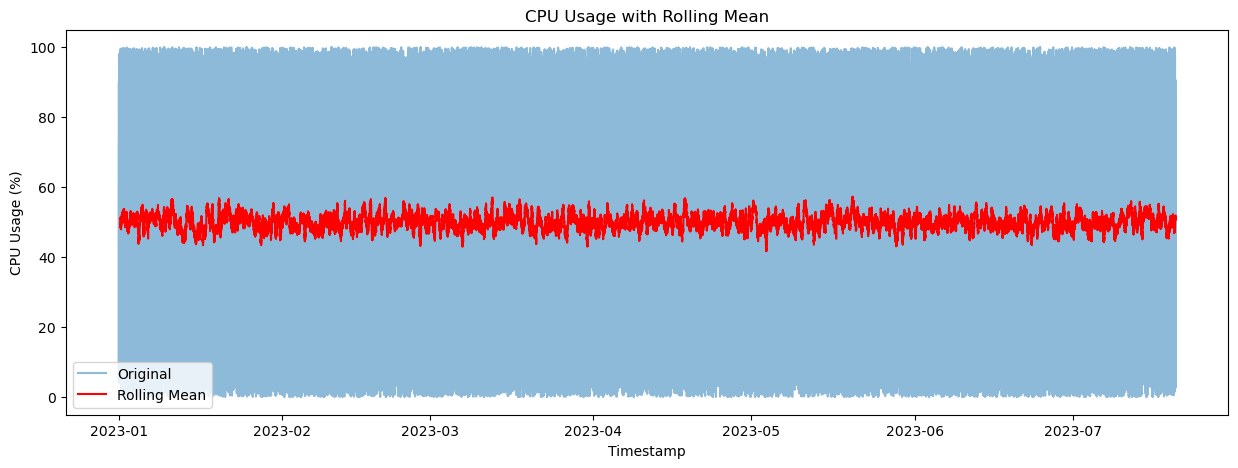

In [23]:
# Ensure timestamp is index for time series plotting
df_ts = df.set_index('timestamp')

# Line plot of CPU usage over time
plt.figure(figsize=(15,5))
plt.plot(df_ts['cpu_usage'], color='blue')
plt.title('CPU Usage Over Time')
plt.xlabel('Timestamp')
plt.ylabel('CPU Usage (%)')
plt.show()

# Rolling mean (1-day window if timestamps are frequent)
rolling_window = 144  # approximate if data every 10 min: 6*24=144
df_ts['cpu_usage_roll'] = df_ts['cpu_usage'].rolling(window=rolling_window).mean()

plt.figure(figsize=(15,5))
plt.plot(df_ts['cpu_usage'], alpha=0.5, label='Original')
plt.plot(df_ts['cpu_usage_roll'], color='red', label='Rolling Mean')
plt.title('CPU Usage with Rolling Mean')
plt.xlabel('Timestamp')
plt.ylabel('CPU Usage (%)')
plt.legend()
plt.show()

### Bivariate & Multivariate Analysis.

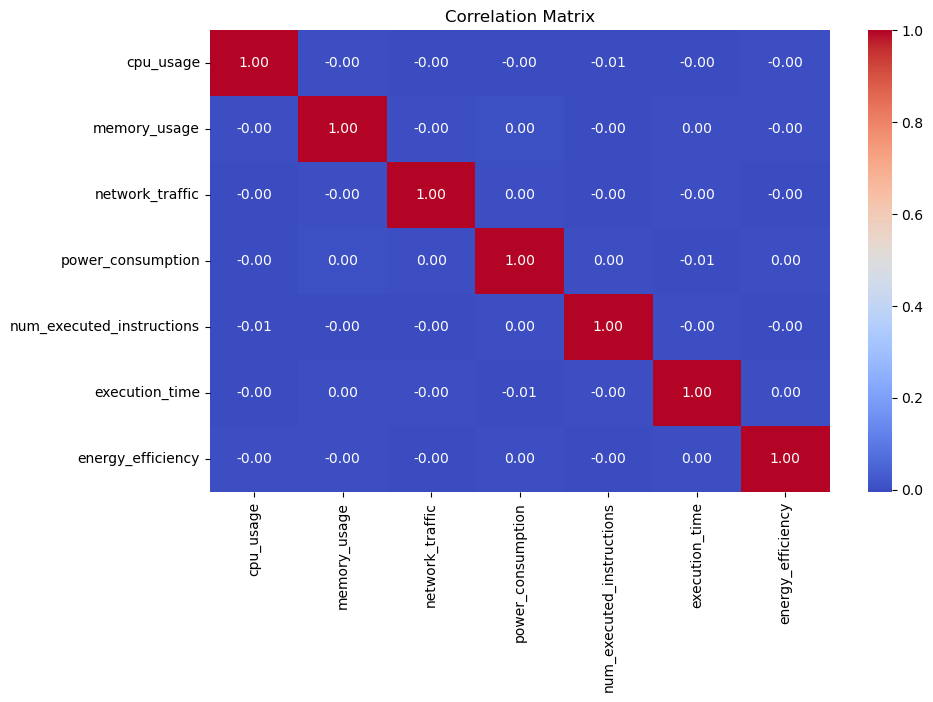

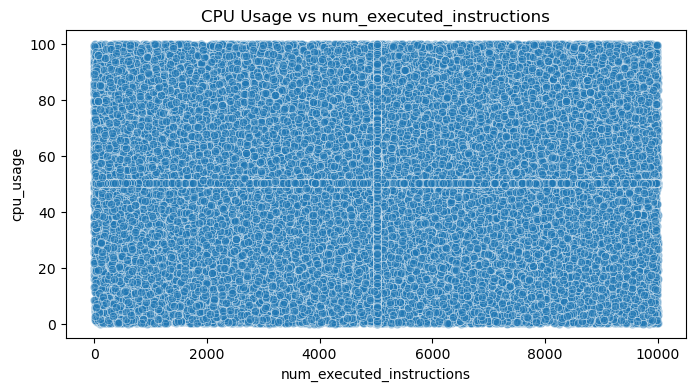

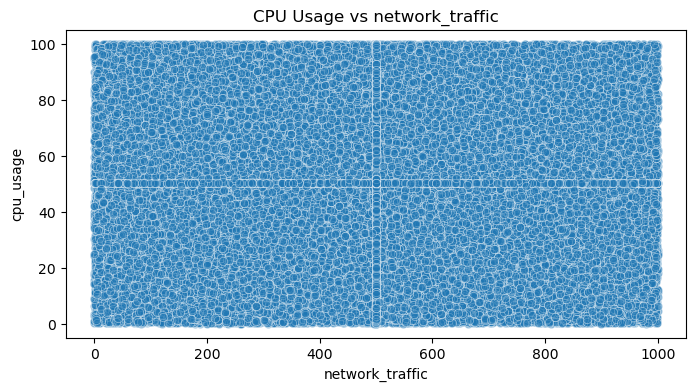

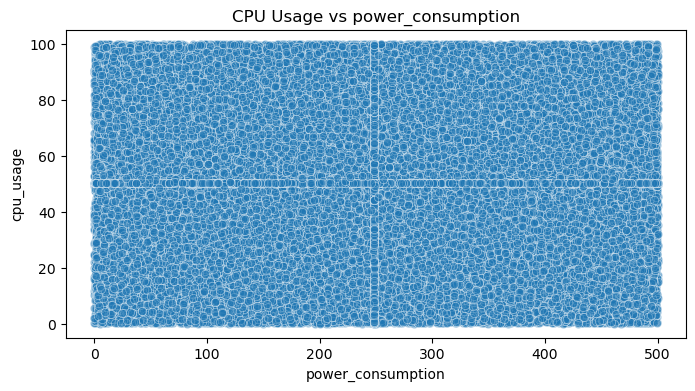

In [24]:
# Correlation matrix for numerical features
num_cols = ['cpu_usage', 'memory_usage', 'network_traffic', 
            'power_consumption', 'num_executed_instructions', 
            'execution_time', 'energy_efficiency']

corr = df[num_cols].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Scatter plots for top correlated features with CPU usage
top_features = corr['cpu_usage'].abs().sort_values(ascending=False).index[1:4]

for feature in top_features:
    plt.figure(figsize=(8,4))
    sns.scatterplot(data=df, x=feature, y='cpu_usage', alpha=0.5)
    plt.title(f'CPU Usage vs {feature}')
    plt.show()

- The correlation matrix confirms virtually no linear relationships among the numerical features.
- Scatter plots visually validate that cpu_usage doesn’t linearly depend on features like num_executed_instructions, network_traffic, or power_consumption.
- This suggests that simple linear models may struggle, and advanced models (like Random Forest, XGBoost, or LSTM) that capture non-linear patterns will likely perform better.

In [25]:
# Make sure timestamp is datetime and sorted
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

# Set timestamp as index
df_ts = df.set_index('timestamp')

# --- Lag Features ---
lags = [1, 5, 10]  # lag steps
for lag in lags:
    df_ts[f'cpu_usage_lag_{lag}'] = df_ts['cpu_usage'].shift(lag)

# --- Rolling Window Statistics ---
windows = [3, 6, 12]  # previous n steps
for window in windows:
    df_ts[f'cpu_usage_roll_mean_{window}'] = df_ts['cpu_usage'].rolling(window=window).mean()
    df_ts[f'cpu_usage_roll_std_{window}'] = df_ts['cpu_usage'].rolling(window=window).std()
    df_ts[f'cpu_usage_roll_min_{window}'] = df_ts['cpu_usage'].rolling(window=window).min()
    df_ts[f'cpu_usage_roll_max_{window}'] = df_ts['cpu_usage'].rolling(window=window).max()

# --- Temporal Features ---
df_ts['hour'] = df_ts.index.hour
df_ts['day_of_week'] = df_ts.index.dayofweek
df_ts['month'] = df_ts.index.month
df_ts['is_weekend'] = df_ts['day_of_week'].isin([5,6]).astype(int)

# Drop rows with NaN values generated by lag/rolling
df_ts = df_ts.dropna()

print("Columns after feature generation:")
print(df_ts.columns)


Columns after feature generation:
Index(['vm_id', 'cpu_usage', 'memory_usage', 'network_traffic',
       'power_consumption', 'num_executed_instructions', 'execution_time',
       'energy_efficiency', 'task_type', 'task_priority', 'task_status',
       'cpu_usage_lag_1', 'cpu_usage_lag_5', 'cpu_usage_lag_10',
       'cpu_usage_roll_mean_3', 'cpu_usage_roll_std_3', 'cpu_usage_roll_min_3',
       'cpu_usage_roll_max_3', 'cpu_usage_roll_mean_6', 'cpu_usage_roll_std_6',
       'cpu_usage_roll_min_6', 'cpu_usage_roll_max_6',
       'cpu_usage_roll_mean_12', 'cpu_usage_roll_std_12',
       'cpu_usage_roll_min_12', 'cpu_usage_roll_max_12', 'hour', 'day_of_week',
       'month', 'is_weekend'],
      dtype='object')


In [26]:
# Categorical columns
cat_cols = ['vm_id', 'task_type', 'task_priority', 'task_status']

# One-hot encoding for low-cardinality categorical features
# (vm_id may be high-cardinality; we can drop it or use target encoding later)
df_encoded = pd.get_dummies(df_ts, columns=['task_type', 'task_priority', 'task_status'], drop_first=True)

# Optionally, for vm_id (high-cardinality), you could use label encoding or drop
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# df_encoded['vm_id_encoded'] = le.fit_transform(df_ts['vm_id'])
# df_encoded = df_encoded.drop('vm_id', axis=1)

print("Columns after categorical encoding:")
print(df_encoded.columns)


Columns after categorical encoding:
Index(['vm_id', 'cpu_usage', 'memory_usage', 'network_traffic',
       'power_consumption', 'num_executed_instructions', 'execution_time',
       'energy_efficiency', 'cpu_usage_lag_1', 'cpu_usage_lag_5',
       'cpu_usage_lag_10', 'cpu_usage_roll_mean_3', 'cpu_usage_roll_std_3',
       'cpu_usage_roll_min_3', 'cpu_usage_roll_max_3', 'cpu_usage_roll_mean_6',
       'cpu_usage_roll_std_6', 'cpu_usage_roll_min_6', 'cpu_usage_roll_max_6',
       'cpu_usage_roll_mean_12', 'cpu_usage_roll_std_12',
       'cpu_usage_roll_min_12', 'cpu_usage_roll_max_12', 'hour', 'day_of_week',
       'month', 'is_weekend', 'task_type_io', 'task_type_network',
       'task_priority_low', 'task_priority_medium', 'task_status_running',
       'task_status_waiting'],
      dtype='object')


In [27]:
# Identify numerical columns (exclude target 'cpu_usage')
num_cols = df_encoded.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols.remove('cpu_usage')  # target variable

# Initialize scaler
scaler = StandardScaler()

# Fit on numerical features and transform
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

print("Numerical columns after scaling:")
print(df_encoded[num_cols].head())


Numerical columns after scaling:
                     memory_usage  network_traffic  power_consumption  \
timestamp                                                               
2023-01-01 00:49:23     -0.175410        -1.556040          -1.336771   
2023-01-01 00:49:38     -0.303054        -1.451100          -0.002628   
2023-01-01 00:52:51     -0.729701        -1.817132          -0.749918   
2023-01-01 00:55:05      1.164166        -0.142950          -1.333421   
2023-01-01 00:55:09      1.091293         0.534507           0.044188   

                     num_executed_instructions  execution_time  \
timestamp                                                        
2023-01-01 00:49:23                  -0.011757        0.706100   
2023-01-01 00:49:38                   0.834610       -0.002973   
2023-01-01 00:52:51                   0.890206        1.670615   
2023-01-01 00:55:05                   1.776442       -0.669732   
2023-01-01 00:55:09                   1.730356        1.052

In [28]:
# Features (X) and target (y), drop vm_id
X = df_encoded.drop(['cpu_usage', 'vm_id'], axis=1)
y = df_encoded['cpu_usage']

# Lasso with cross-validation to find optimal alpha
lasso = LassoCV(cv=5, random_state=42, max_iter=5000)
lasso.fit(X, y)

# Get feature importance
importance = pd.Series(np.abs(lasso.coef_), index=X.columns)
selected_features = importance[importance > 0].sort_values(ascending=False)

print("Top selected features:\n", selected_features.head(20))


Top selected features:
 cpu_usage_roll_mean_3        23.442788
cpu_usage_lag_1              13.614422
cpu_usage_roll_max_3          0.196531
num_executed_instructions     0.054785
network_traffic               0.049270
cpu_usage_lag_5               0.038191
hour                          0.000646
dtype: float64


In [29]:
# Sort by timestamp
df_encoded = df_encoded.sort_values('timestamp')

# Select features based on Lasso (keep only top ones)
top_features = selected_features.index.tolist()
X = df_encoded[top_features]
y = df_encoded['cpu_usage']

# Split: 70% train, 15% validation, 15% test
train_size = 0.7
val_size = 0.15

n = len(df_encoded)
train_end = int(n * train_size)
val_end = int(n * (train_size + val_size))

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")


Train shape: (62977, 7), Validation shape: (13495, 7), Test shape: (13496, 7)


In [30]:
# Baseline prediction: previous value (lag_1)
y_pred_baseline = X_val['cpu_usage_lag_1'].values

rmse_baseline = np.sqrt(mean_squared_error(y_val, y_pred_baseline))
mae_baseline = mean_absolute_error(y_val, y_pred_baseline)

print(f"Baseline RMSE: {rmse_baseline:.4f}, MAE: {mae_baseline:.4f}")


Baseline RMSE: 56.8596, MAE: 49.8072


In [31]:
# Dictionary to store models
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    # Train
    model.fit(X_train, y_train)
    # Predict
    y_pred = model.predict(X_val)
    # Metrics
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    results[name] = {"RMSE": rmse, "MAE": mae}
    print(f"{name} -> RMSE: {rmse:.4f}, MAE: {mae:.4f}")


Random Forest -> RMSE: 20.0624, MAE: 15.9566
Gradient Boosting -> RMSE: 19.5368, MAE: 15.9238
XGBoost -> RMSE: 20.0105, MAE: 16.1172


In [32]:

for name, model in models.items():
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    print(f"{name} -> RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")


Random Forest -> RMSE: 20.0624, MAE: 15.9566, R²: 0.4639
Gradient Boosting -> RMSE: 19.5368, MAE: 15.9238, R²: 0.4916
XGBoost -> RMSE: 20.0105, MAE: 16.1172, R²: 0.4666


In [34]:

# Generate parameter combinations
param_list = list(ParameterSampler(param_dist, n_iter=10, random_state=42))

best_score = float('inf')
best_params = None
best_model = None

# Loop over each combination with a progress bar
for params in tqdm(param_list, desc="Hyperparameter Tuning"):
    model = GradientBoostingRegressor(random_state=42, **params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    if rmse < best_score:
        best_score = rmse
        best_params = params
        best_model = model

# Final evaluation
y_pred_final = best_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_final))
mae = mean_absolute_error(y_val, y_pred_final)
r2 = r2_score(y_val, y_pred_final)

print("Best Parameters:", best_params)
print(f"Tuned Gradient Boosting -> RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")


Hyperparameter Tuning: 100%|████████████████████████████████████████████████████████████████████████| 10/10 [05:16<00:00, 31.67s/it]

Best Parameters: {'learning_rate': np.float64(0.15248952782381875), 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 84, 'subsample': np.float64(0.9727961206236346)}
Tuned Gradient Boosting -> RMSE: 19.5148, MAE: 15.9018, R²: 0.4927


In [37]:


# Define full path
model_path = r"C:\Users\37789\OneDrive\Documents\GitHub\Cloud_CPU_Usage_Forecasting\src\models\gradient_boosting_model.pkl"

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(model_path), exist_ok=True)

# Save the trained model
joblib.dump(best_model, model_path)

print("Model saved successfully at:", model_path)


Model saved successfully at: C:\Users\37789\OneDrive\Documents\GitHub\Cloud_CPU_Usage_Forecasting\src\models\gradient_boosting_model.pkl
